In [413]:
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.linalg as la
import scipy.integrate as sciint
from itertools import product
from functools import partial

import os

# Mine
from wilson_cowan_2d.simulations import concrete_wc_kernel as wck
from wilson_cowan_2d.simulations import wc_params as wcp
from wilson_cowan_2d.simulations.nonlinear_functions import decreasing_exponential
from wilson_cowan_2d.analysis import nulclines as nuc
from wilson_cowan_2d.analysis import stability as sta

# Jupyter Specific
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Fixed Point Analysis

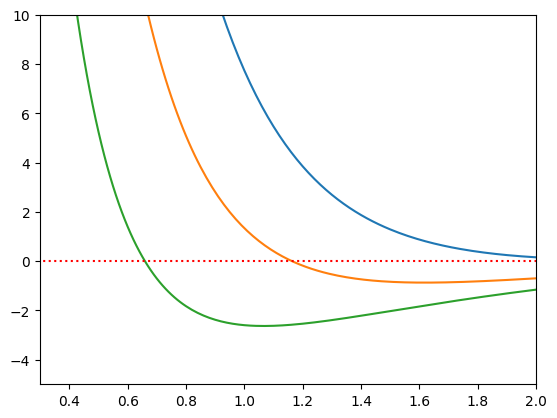

In [3]:
τe = 1
τi = 0.5 * τe
σe = 1
σi = 2 * σe
ω = 0.8

u_bar, v_bar = np.array([0.424, 0.204])
param = wcp.DefaultParams(τ = np.array([τe, τi]), η = 0.1, size = 2**8, σ = np.array([σe, σi]))

rang = np.linspace(0,100, 10_000)
dw_test = sta.calc_Dω_range(param, (u_bar, v_bar), 1, (2,3,5), rang)

_ = [plt.plot(rang, dw) for dw in dw_test]
# _ = plt.legend()
_ = plt.xlim(0.3, 2)
_ = plt.ylim(-5, 10)
_ = plt.hlines(0,0,1_000, color='r', linestyle=":")

### Periodic Oribit Analysis

In [4]:
ωs = np.linspace(0, 1, 10)
σs = τs = np.linspace(0.5,1,21)

In [351]:
period = 0.18

In [352]:
τ_output = list()
τ_err_list = list()
  # np.linspace(0.5,2.5,21)

τ = 0.01

τi = τ * τe

for ix, τ in enumerate(np.arange(0.1, 0.7, 0.01)):
    τe = 1
    param = wcp.DefaultParams(τ = np.array([τe, τe*τ]).reshape(2,1), η = 1, size = 1)
    # param.Θ = np.array([0.08, 0.4])

    inp = np.array([0.4, 0.2]).reshape(2,1)

    test = wck.WCUnif(inp, param)
    end = 5
    ures = test((0, end), t_eval=np.arange(0, end, 0.1)) 
    uv_init = ures._solved.y.T[-1].reshape(2,1)

    # Find Period
    def find_period_func(T):
        start = wck.WCUnif(uv_init, param)
        res = start((0,T),simple=True, t_eval=(0,T))
        return np.sum(np.abs(uv_init - res.y.T[-1].reshape(2,1)))  # , res

    period = opt.fsolve(find_period_func, period, factor=0.01)[0]
    i = 1
    while(i < 100 and period < 0.001):
        retry = 1 + 0.01*i
        period = opt.fsolve(find_period_func, retry, factor=0.01)[0]
        i+=1
    if i >= 100:
        print(f"{τ} didn't resolve. Final period: {period}")
        τ_err_list.append(τ)
        continue
        

    test = wck.WCUnif(uv_init, param)
    new_res = test((0,period), simple=True)

    new_u, new_v = new_res.y
    τ_output.append((τ, period, uv_init, (new_u, new_v)))
    
    if ix % 1 == 0:
        clear_output(wait=True)
        print("On iter: ", ix, period)
    # _=  plt.plot(new_u, new_v)

On iter:  57 2.879637587120112
0.6799999999999997 didn't resolve. Final period: -6.91569467043177e-18
0.6899999999999997 didn't resolve. Final period: 4.3701423813601556e-17


In [353]:
# gen = iter(τ_output)

In [574]:
# τ, period, _, (new_u, new_v) = next(gen)

# print("Period: ", period, "for τ: ", τ)
# plt.plot(new_u, new_v)


In [416]:
# with open("theta:0125_04_tau_period_output_list.pkl",'wb') as w:
#     pkl.dump(τ_output, w)

In [419]:

    for ix, (ω, σ) in enumerate(product(ωs, σs)):
        σe = 1
        σi = σ * σe
        param = wcp.MondronomyParams\
        .default(τ = np.array([τe, τi]), η = 1, size = 1, σ=np.array([σe, σi]), ω=ω)

        # Find Mondronomy Matrix
        def update(t, inp):
            X  = inp[0:4].reshape(2,2)
            u, v = inp[4:]
            A, (θe, θi), (τe, τi), η, (σe, σi), ω = param.derivative_tuple
            F = param.F
            AA = sta.calc_AA(u, v, param)

            dX = (AA @ X).ravel()
            du = F(A[0,0]*u - A[0,1]*v - θe) - u
            dv = (F(A[1,0]*u - A[1,1]*v - θi) - v)/τi

            return _make_inp(dX, np.array([du, dv]))

        def _make_inp(X, uv):
            return np.concatenate((X.ravel(), uv.ravel()))

        inp = _make_inp(np.eye(2).ravel(), uv_init)  # Inital Condition
        new_res = sciint.solve_ivp(update, (0, period), inp)

        # Calc Q
        X = new_res.y[:4].T[-1].reshape(2,2)
        Q = 1 + np.trace(X) + la.det(X)

        if ix % 222-1 == 1:
            clear_output(wait=True)
            print(f"On iter: {ix: >6}, params <- σ:{σ:>0.2}, τ:{τ:>0.2}, ω:{ω:>0.2}, Q:{Q:>0.2}") 

        output.append({"σ":σ, "τ":τ, "ω":ω, "Q":Q})

On iter:  14210, params <- σ:1.6, τ:0.11, ω:0.84, Q:0.74


KeyboardInterrupt: 

In [421]:
len(ωs)*len(σs)

45600

In [429]:
output = list()
# Initial Condition
σe = 1
τe = 1

output = list()
ωs = np.arange(0.1, 2.5, 0.02)
σs = τs = np.arange(0.1, 2, 0.02)
ωσ_len = len(ωs)*len(σs)

for it, (τ, period, uv_init, _) in enumerate(τ_output):
    if τ < 0.25: continue
    τi = τ * τe
    inp = np.concatenate((np.eye(2).ravel(), uv_init.ravel()))
    for ix, (ω, σ) in enumerate(product(ωs, σs)):
        σi = σ * σe
        param = wcp.MondronomyParams\
        .default(τ = np.array([τe, τi]), η = 1, size = 1, σ=np.array([σe, σ*σ]), ω=ω)

        # Find Mondronomy Matrix
        new_res = wck.WCDecExpMondronomy(inp, param)((0, period))

        # Calc Q
        X = new_res.y[:4].T[-1].reshape(2,2)
        Q = 1 + np.trace(X) + la.det(X)

        if ix  % 632 == 1:
            clear_output(wait=True)
            print(f"On iter: {ix+ it*ωσ_len: >8}, params <- σ:{σ:>0.2}, τ:{τ:>0.2}, ω:{ω:>0.2}, Q:{Q:>0.2}") 

        test_output.append({"σ":σ, "τ":τ, "ω":ω, "Q":Q})

On iter:   661177, params <- σ:1.5, τ:0.67, ω:2.5, Q:1.2


In [430]:
out = pd.DataFrame(test_output)
# output_saves[τ] = out
out.loc[lambda x: x.Q < 0].min(axis=0)

σ     0.100000
τ     0.260000
ω     0.100000
Q   -23.258877
dtype: float64

In [431]:
# with open("Mondronomy Q Measures theta: 0125-04.pkl", 'wb') as w:
#     pkl.dump(out, w)

In [443]:
out

,σ,τ,ω,Q
213796,0.10,0.26,0.10,3.626058
213797,0.11,0.26,0.10,3.626060
213798,0.12,0.26,0.10,3.626063
213799,0.13,0.26,0.10,3.626066
213800,0.14,0.26,0.10,3.626071
...,...,...,...,...
427758,1.90,0.26,2.48,2.846360
427759,1.92,0.26,2.48,2.849540
427760,1.94,0.26,2.48,2.852565
427761,1.96,0.26,2.48,2.855445


In [503]:
plot_dat = out.loc[lambda x: x.Q < 0].groupby("τ").agg(σ_min=('σ','min'))

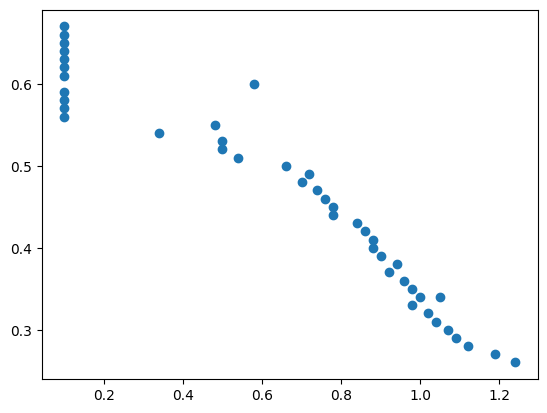

In [507]:
plt.scatter(plot_dat.σ_min, plot_dat.index)

0.5299999999999998

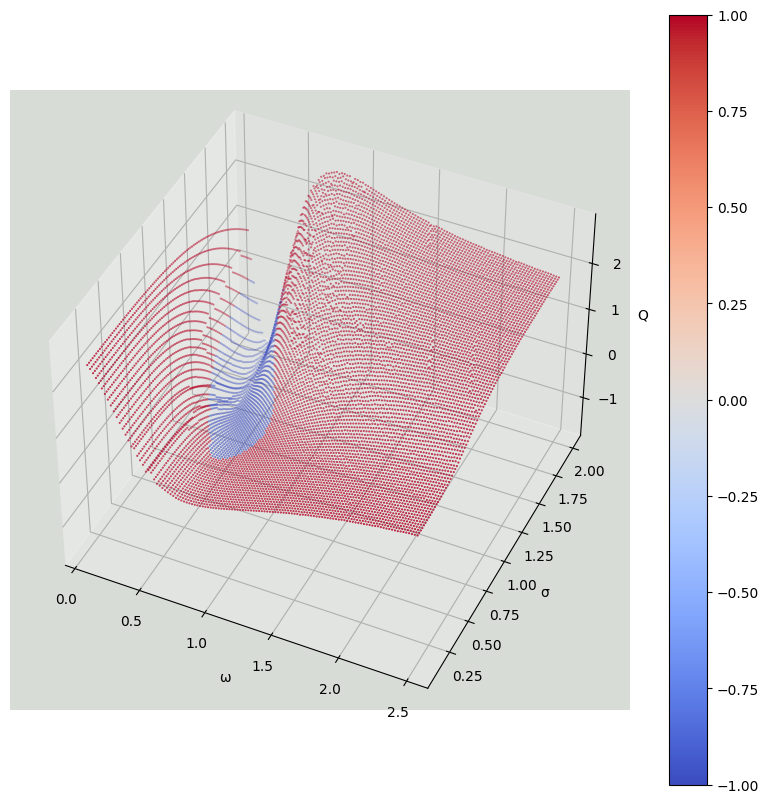

In [493]:
τemp = out.τ.unique()[32]
dat = out.loc[lambda x: x.τ == τemp]

fig_name = f"linear_stability_tau-{τemp}.png"
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

im = ax.scatter(dat.ω, dat.σ, np.sign(dat.Q)*(np.abs(dat.Q)), c=np.sign(dat.Q)
                , s=0.25, cmap=cm.coolwarm)
_ = ax.set_ylabel('σ')
_ = ax.set_xlabel('ω')
_ = ax.set_zlabel('Q')

ax.set_facecolor('xkcd:light gray')
ax.view_init(42, -65)

τemp
_ = plt.colorbar(im)

# plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')

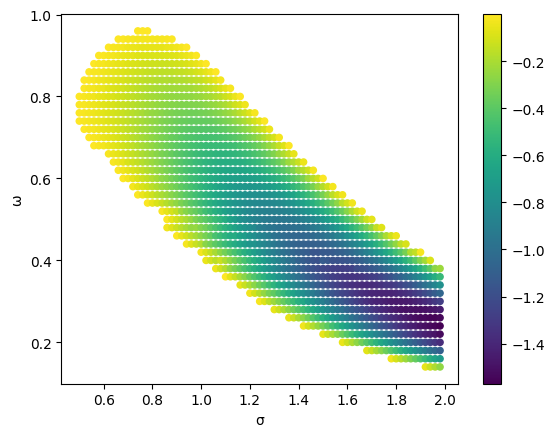

In [494]:
fig_name = f"linear_stability_negitive_projection_tau-{τ}.png"
sdat = dat.loc[lambda x: x.Q <0][['ω', 'σ', 'Q']]
_ = plt.scatter(sdat.σ, sdat.ω, s=20, cmap=cm.viridis, c=sdat.Q)
_ = plt.xlabel("σ")
_ = plt.ylabel("ω")
_ = plt.colorbar()

# plt.facecolor('xkcd:light gray')

# plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')

In [508]:
import multiprocessing as mp

In [562]:
# τ, period, uv_init, _ = τ_output[20]
ωs = np.round(np.arange(0.1, 2.5, 0.05), 2)
σs = np.round(np.arange(0.1, 2, 0.05), 2)
inp = np.concatenate((np.eye(2).ravel(), uv_init.ravel()))
params = [wcp.MondronomyParams.default(np.array([1, τ]), 1, 1, np.array([1, σ]), ω)
            for ω, σ in product(ωs, σs)]

full_params = list()
for ((τ, p, init, _), ω, σ) in product(τ_output, ωs, σs):
    param = wcp.MondronomyParams.default(np.array([1, τ]), 1, 1, np.array([1, σ]), ω)
    inp = np.concatenate((np.eye(2).ravel(), init.ravel()))
    full_params.append((p, inp, param))

def f(fparam):
    period, inp, param = fparam

    res = wck.WCDecExpMondronomy(inp, param)((0, period))
    X = res.y[:4].T[-1].reshape(2,2)
    Q = 1 + np.trace(X) + la.det(X)
    return {"σ": param.σ[1], "τ":param.τ[1], "ω": param.ω, "Q":Q}
    
output = list()
with mp.Pool(8) as pool:
    for t in pool.imap_unordered(f, iter(full_params)):
        output.append(t)
    
    

In [563]:
out = pd.DataFrame(output)

In [564]:
out.size

423168

In [565]:
with open("Mondronomy_001_for_theta_0125_04.pkl", 'wb') as w:
    pkl.dump(out, w)

In [ ]:
out.plot()

<Axes: xlabel='σ_min', ylabel='τ'>

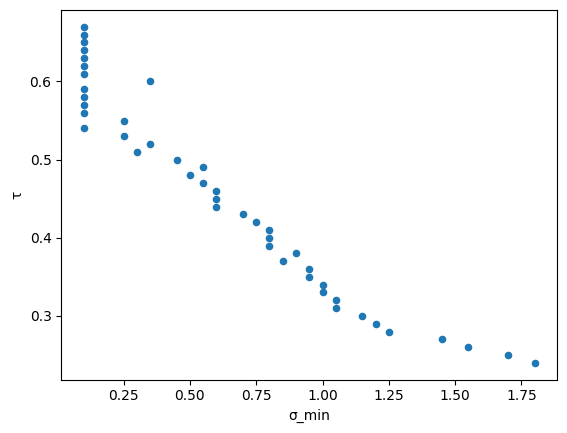

In [573]:
out.loc[lambda x: x.Q < 0].groupby("τ").agg(σ_min=('σ','min'), τ=('τ', 'unique')).plot(y='τ', x='σ_min', kind='scatter')

In [557]:
out.Q.unique()

array([1.1653989])